In [ ]:
# Import Statements
import pandas as pd
import numpy as np
import csv
import gensim
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from nltk.stem.porter import PorterStemmer
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.pipeline import Pipeline
from nltk.corpus import stopwords
from string import punctuation
import seaborn as sns
import pandas as pd
import numpy as np
import nltk
import re
import matplotlib.pyplot as plt
from scipy import sparse
from keras.models import Sequential
from keras.layers import Dense

# Read the news dataset
df=pd.read_csv(r'project_data.csv')
print(df.iloc[0])
print(df.shape)

title    Donald Trump Caught Snorting Cocaine by Hotel ...
text     The Internet is buzzing today after white supr...
label                                                    1
Name: 0, dtype: object
(251, 3)


In [ ]:
# Download useful packages from nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('vader_lexicon')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [ ]:
# Enforce correct types over the dataset features
df['title'] = df['title'].astype('str') 
df['text'] = df['text'].astype('str')
news=df 
news.head()

,title,text,label
0,Donald Trump Caught Snorting Cocaine by Hotel ...,The Internet is buzzing today after white supr...,1
1,Donald Trump Hires Clueless Stacey Dash for Ne...,TRUMP TOWER With his poll numbers among black...,1
2,Donald Trump Meets With WWE Owner Vince McMaho...,Donald Trump is looking to assemble a strong t...,1
3,Donald Trump Picks Stacey Dash as His Vice Pre...,SHES SEXY SMART SOPHISTICATED AND SHES INTO...,1
4,Donald Trump Protester Speaks Out I Was Paid ...,PHOENIX A.Z. AP For months now rumors have...,1


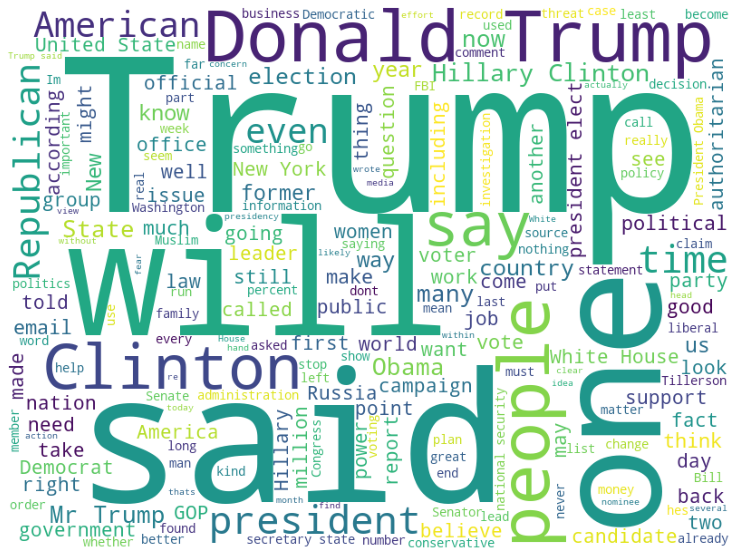

In [ ]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

%matplotlib inline
def cloud(data,backgroundcolor = 'white', width = 800, height = 600):
    wordcloud = WordCloud(stopwords = STOPWORDS, background_color = backgroundcolor,
                         width = width, height = height).generate(data)
    plt.figure(figsize = (15, 10))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()
    
cloud(' '.join(news['text']))

# 1)Sentimental Features
## This section extracts 2 features:
## a) Polarity ( 1,0,-1 based on positive, neutral and negative news)
## b) Sentiment score or subjective score 




In [ ]:
def cleaning(raw_news):
    import nltk
    
    # 1. Remove non-letters/Special Characters and Punctuations
    news = re.sub("[^a-zA-Z]", " ", raw_news)
    
    # 2. Convert to lower case.
    news =  news.lower()
    
    # 3. Tokenize.
    news_words = nltk.word_tokenize( news)
    
    
    # 8. Join the stemmed words back into one string separated by space, and return the result.
    return " ".join(news_words)
clean_text=[]
for i in news['text']:
  clean_text.append(cleaning(i))

news['clean_text'] = clean_text
news.head()

,title,text,label,clean_text
0,Donald Trump Caught Snorting Cocaine by Hotel ...,The Internet is buzzing today after white supr...,1,the internet is buzzing today after white supr...
1,Donald Trump Hires Clueless Stacey Dash for Ne...,TRUMP TOWER With his poll numbers among black...,1,trump tower with his poll numbers among black ...
2,Donald Trump Meets With WWE Owner Vince McMaho...,Donald Trump is looking to assemble a strong t...,1,donald trump is looking to assemble a strong t...
3,Donald Trump Picks Stacey Dash as His Vice Pre...,SHES SEXY SMART SOPHISTICATED AND SHES INTO...,1,shes sexy smart sophisticated and shes into ol...
4,Donald Trump Protester Speaks Out I Was Paid ...,PHOENIX A.Z. AP For months now rumors have...,1,phoenix a z ap for months now rumors have circ...


In [ ]:
polar=[]
cmp_score=[]
from textblob import TextBlob
def senti(x):
    return TextBlob(x).sentiment  
for i in news['clean_text']:
  t=cleaning(i)
  x=senti(t)
  polar.append(x[0])
  cmp_score.append(x[1])


news['polarity'] = polar
news['sentiment_score'] = cmp_score


In [ ]:
# Function to obtain the sentiment vector of a tuple
import warnings
import nltk.sentiment
warnings.filterwarnings('ignore')
senti = nltk.sentiment.vader.SentimentIntensityAnalyzer()
def get_polarity_type(sentence):
    sentimentVector = []
    snt = senti.polarity_scores(sentence)
    sentimentVector.append(snt['neg'])
    sentimentVector.append(snt['neu'])
    sentimentVector.append(snt['pos'])
    sentimentVector.append(snt['compound'])
    
    return sentimentVector

/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [ ]:
# Calculate the Sentiment Vector, Polarity and Sentiment Score of each tuple and append into the dataset
sentiment = []
polar = []
cmp_score = []
for i in news['clean_text']:
    get_pols = get_polarity_type(i)
    sentiment.append(get_pols[1:])
     
    
#news['sentiment_vector'] = sentiment


In [ ]:
# View the modified dataset
news.head()

,title,text,label,clean_text,polarity,sentiment_score
0,Donald Trump Caught Snorting Cocaine by Hotel ...,The Internet is buzzing today after white supr...,1,the internet is buzzing today after white supr...,-0.090000,0.325000
1,Donald Trump Hires Clueless Stacey Dash for Ne...,TRUMP TOWER With his poll numbers among black...,1,trump tower with his poll numbers among black ...,0.091027,0.402559
2,Donald Trump Meets With WWE Owner Vince McMaho...,Donald Trump is looking to assemble a strong t...,1,donald trump is looking to assemble a strong t...,0.111726,0.558531
3,Donald Trump Picks Stacey Dash as His Vice Pre...,SHES SEXY SMART SOPHISTICATED AND SHES INTO...,1,shes sexy smart sophisticated and shes into ol...,0.283036,0.476190
4,Donald Trump Protester Speaks Out I Was Paid ...,PHOENIX A.Z. AP For months now rumors have...,1,phoenix a z ap for months now rumors have circ...,0.113917,0.453070


# 2)Syntax Based Features
## This section extracts 6 Syntax-based features:
## a)characters count(with spaces)
## b)words count
## c)Uppercase word count
## d)Stop word count
## e)word count in the title
## f)word density

In [ ]:
# Compute the Syntax-based features
import string 
total_words=0
char_count=[]
word_count=[]
uword_count=[]
tword_count=[]
stop_count=[]
word_density=[]
for i in news['clean_text']:
  char_count.append(len(i))
  word_count.append(sum([i.strip(string.punctuation).isalpha() for i in i.split()]))
  uword_count.append(sum(([i.strip(string.punctuation).isupper() for i in i.split()])))
  news_words = nltk.word_tokenize(i)
  total_words+=len(list(set(news_words)))
  stops = set(nltk.corpus.stopwords.words("english"))
  words = [w for w in  news_words  if w in stops]
  stop_count.append(len(words))
  #fd = nltk.FreqDist(words)
  #for j in fd:
    #fd[j]=fd[j]/(sum([i.strip(string.punctuation).isalpha() for i in i.split()]))
  #word_density.append(fd)

for i in news['title']:
  tword_count.append(sum([i.strip(string.punctuation).isalpha() for i in i.split()]))

# Append the calculated features to the existing dataset
news['char_count'] = char_count
news['word_count'] = word_count
news['title_word_count'] = tword_count
news['stop_word_count'] = stop_count
news['upper_case_word_count'] = uword_count

In [ ]:
# View the modified dataset
news.head()

,title,text,label,clean_text,polarity,sentiment_score,char_count,word_count,title_word_count,stop_word_count,upper_case_word_count
0,Donald Trump Caught Snorting Cocaine by Hotel ...,The Internet is buzzing today after white supr...,1,the internet is buzzing today after white supr...,-0.090000,0.325000,1165,231,8,111,0
1,Donald Trump Hires Clueless Stacey Dash for Ne...,TRUMP TOWER With his poll numbers among black...,1,trump tower with his poll numbers among black ...,0.091027,0.402559,2242,390,10,166,0
2,Donald Trump Meets With WWE Owner Vince McMaho...,Donald Trump is looking to assemble a strong t...,1,donald trump is looking to assemble a strong t...,0.111726,0.558531,1374,253,13,97,0
3,Donald Trump Picks Stacey Dash as His Vice Pre...,SHES SEXY SMART SOPHISTICATED AND SHES INTO...,1,shes sexy smart sophisticated and shes into ol...,0.283036,0.476190,500,98,12,50,0
4,Donald Trump Protester Speaks Out I Was Paid ...,PHOENIX A.Z. AP For months now rumors have...,1,phoenix a z ap for months now rumors have circ...,0.113917,0.453070,7339,1347,12,638,0


# 3) Grammatical Features
## This section computes 5 Grammatical features:
## a)Noun count
## b)Verb count
## c)Adjective count
## d)Pronoun count
## e)Adverb count

In [ ]:
# Calculate the Grammatical Features
from collections import Counter

noun_count=[]
verb_count=[]
adjective_count=[]
pronoun_count=[]
adverb_count=[]
lexical_density=[]
word_count=[]
index = 0

for i in news['clean_text']:
  news_words = nltk.word_tokenize(i)
  text = nltk.Text(news_words)
  tags = nltk.pos_tag(text)
  counts=(Counter(tag for word,tag in tags))

  word_count.append(sum([i.strip(string.punctuation).isalpha() for i in i.split()]))
  
  noun_count.append(counts['NN']+counts['NNS']+counts['NNP'])
  adjective_count.append(counts['JJ']+counts['JJR']+counts['JJS'])
  verb_count.append(counts['VB']+counts['VBD']+counts['VBG']+counts['VBN']+counts['VBP']+counts['VBZ'])
  pronoun_count.append(counts['PRP']+counts['PRP$']+counts['WP']+counts['WP$'])
  adverb_count.append(counts['RB']+counts['RBR']+counts['RBS']+counts['WRB'])
  lexical_density.append((noun_count[index] + verb_count[index] + adjective_count[index] + adverb_count[index]) / word_count[index])
  


# Append the calculated features to the existing dataset
news['lexical_density'] = lexical_density
news['noun_count'] = noun_count
news['verb_count'] = verb_count
news['adjective_count'] = adjective_count
news['pronoun_count'] = pronoun_count
news['adverb_count'] = adverb_count

In [ ]:
# View the modified dataset
news.head()

,title,text,label,clean_text,polarity,sentiment_score,char_count,word_count,title_word_count,stop_word_count,upper_case_word_count,lexical_density,noun_count,verb_count,adjective_count,pronoun_count,adverb_count
0,Donald Trump Caught Snorting Cocaine by Hotel ...,The Internet is buzzing today after white supr...,1,the internet is buzzing today after white supr...,-0.090000,0.325000,1165,231,8,111,0,0.645022,72,55,13,20,9
1,Donald Trump Hires Clueless Stacey Dash for Ne...,TRUMP TOWER With his poll numbers among black...,1,trump tower with his poll numbers among black ...,0.091027,0.402559,2242,390,10,166,0,0.645022,110,80,32,34,24
2,Donald Trump Meets With WWE Owner Vince McMaho...,Donald Trump is looking to assemble a strong t...,1,donald trump is looking to assemble a strong t...,0.111726,0.558531,1374,253,13,97,0,0.645022,71,61,26,29,8
3,Donald Trump Picks Stacey Dash as His Vice Pre...,SHES SEXY SMART SOPHISTICATED AND SHES INTO...,1,shes sexy smart sophisticated and shes into ol...,0.283036,0.476190,500,98,12,50,0,0.645022,25,14,9,9,1
4,Donald Trump Protester Speaks Out I Was Paid ...,PHOENIX A.Z. AP For months now rumors have...,1,phoenix a z ap for months now rumors have circ...,0.113917,0.453070,7339,1347,12,638,0,0.645022,363,298,105,115,65


# 4)Readability Features
## Compute 6 Readability Features:
## a)Flesch Reading Ease 
## b)Automated Readability Index
## c)Gunning Fog index 
## d)Flesch-Kincaid score 
## e)The SMOG Index 
## f)Linsear Write formula

In [ ]:
# Function to count number of syllables in a word
def syllables(word):
    count = 0
    vowels = 'aeiouy'
    word = word.lower()
    if word[0] in vowels:
        count +=1
    for index in range(1,len(word)):
        if word[index] in vowels and word[index-1] not in vowels:
            count +=1
    if word.endswith('e'):
        count -= 1
    if word.endswith('le'):
        count += 1
    if count == 0:
        count += 1
    return count

In [ ]:
# Import statements and Declarations
from nltk.tokenize import sent_tokenize
import math
fre=[]
ari=[]
gfi=[]
fks=[]
smog=[]
lwf=[]


# Use number of syllables in the sentence to compute the various Readability Scores
for i in news['text']:
  syllable_count={}
  ncc=len(i)
  nwc=(sum([i.strip(string.punctuation).isalpha() for i in i.split()]))
  uword_count.append(sum(([i.strip(string.punctuation).isupper() for i in i.split()])))
  news_words = nltk.word_tokenize(i)
  total_syllables=0
  hw=0
  ps=0
  ew=0
  
  for j in news_words:
    syllable_count[j]=syllables(j)
    total_syllables+=syllable_count[j]
    if syllable_count[j]>2:
      hw+=1
    if syllable_count[j]>1:
      ps+=1
    if syllable_count[j]<4:
      ew+=1
  news_sentences = sent_tokenize(i)
  nst=len(news_sentences)
  asl=nwc/nst if nst!=0 else 0 
  asw=total_syllables/nwc if nwc!=0 else 0
  phw=100*(hw/nwc if nwc!=0 else 0)
  

  fre.append(206.835 -(1.015 *asl) - (84.6 *asw))
  ari.append(4.71*(ncc/nwc if nwc!=0 else 0)+ 0.5*asl)
  gfi.append(0.4*(asl+phw))
  fks.append(3+math.sqrt(ps))
  smog.append((0.39 *asl) + (11.8 *asw) -15.59)
  x=100 * (nst/nwc if nwc!=0 else 0)
  lwf.append((((100-(100 * (1-(hw/nwc if nwc!=0 else 0))))+(3*(100 *(ew/nwc if nwc!=0 else 0))))/x) if x!=0 else 0)


# Append the computed scores to the dataset
news['fre'] = fre
news['ari'] = ari
news['gfi'] = gfi
news['fks'] = fks
news['smog'] = smog
news['lwf'] = lwf

In [ ]:
# View the modified dataset
news.head()

,title,text,label,clean_text,polarity,sentiment_score,char_count,word_count,title_word_count,stop_word_count,upper_case_word_count,lexical_density,noun_count,verb_count,adjective_count,pronoun_count,adverb_count,fre,ari,gfi,fks,smog,lwf
0,Donald Trump Caught Snorting Cocaine by Hotel ...,The Internet is buzzing today after white supr...,1,the internet is buzzing today after white supr...,-0.090000,0.325000,1165,231,8,111,0,0.645022,72,55,13,20,9,48.043947,43.727500,18.533333,10.874008,15.998421,120.666667
1,Donald Trump Hires Clueless Stacey Dash for Ne...,TRUMP TOWER With his poll numbers among black...,1,trump tower with his poll numbers among black ...,0.091027,0.402559,2242,390,10,166,0,0.645022,110,80,32,34,24,56.424627,34.736845,10.609733,14.575837,8.721585,42.827586
2,Donald Trump Meets With WWE Owner Vince McMaho...,Donald Trump is looking to assemble a strong t...,1,donald trump is looking to assemble a strong t...,0.111726,0.558531,1374,253,13,97,0,0.645022,71,61,26,29,8,65.754595,32.111107,8.710672,12.000000,6.944802,38.000000
3,Donald Trump Picks Stacey Dash as His Vice Pre...,SHES SEXY SMART SOPHISTICATED AND SHES INTO...,1,shes sexy smart sophisticated and shes into ol...,0.283036,0.476190,500,98,12,50,0,0.645022,25,14,9,9,1,53.623750,41.463437,14.883333,8.196152,13.729583,101.666667
4,Donald Trump Protester Speaks Out I Was Paid ...,PHOENIX A.Z. AP For months now rumors have...,1,phoenix a z ap for months now rumors have circ...,0.113917,0.453070,7339,1347,12,638,0,0.645022,363,298,105,115,65,53.879739,38.480883,14.317697,23.566964,11.688710,76.071429


In [ ]:
# Convert the final dataset into csv for use later
news.to_csv('processed_data.csv')

# 5) Final Model

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import csv
import gensim
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from nltk.stem.porter import PorterStemmer
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.pipeline import Pipeline
from nltk.corpus import stopwords
from string import punctuation
import seaborn as sns
import pandas as pd
import numpy as np
import nltk
import re


from keras.models import Sequential
from keras.layers import Dense

In [ ]:
# Read the processed data
from sklearn.utils import shuffle
df = pd.read_csv("processed_data.csv")
#df = shuffle(df)
feature_set = df.iloc[:, 5:]
labels = df.iloc[:, 3]

feature_set_1 = feature_set.iloc[:, 0:-6]
feature_set_2 = feature_set.iloc[:, -6:]
feature_set_3 = feature_set
feature_set.head()

,polarity,sentiment_score,char_count,word_count,title_word_count,stop_word_count,upper_case_word_count,lexical_density,noun_count,verb_count,adjective_count,pronoun_count,adverb_count,fre,ari,gfi,fks,smog,lwf
0,-0.090000,0.325000,1165,231,8,111,0,0.645022,72,55,13,20,9,48.043947,43.727500,18.533333,10.874008,15.998421,120.666667
1,0.091027,0.402559,2242,390,10,166,0,0.645022,110,80,32,34,24,56.424627,34.736845,10.609733,14.575837,8.721585,42.827586
2,0.111726,0.558531,1374,253,13,97,0,0.645022,71,61,26,29,8,65.754595,32.111107,8.710672,12.000000,6.944802,38.000000
3,0.283036,0.476190,500,98,12,50,0,0.645022,25,14,9,9,1,53.623750,41.463437,14.883333,8.196152,13.729583,101.666667
4,0.113917,0.453070,7339,1347,12,638,0,0.645022,363,298,105,115,65,53.879739,38.480883,14.317697,23.566964,11.688710,76.071429


In [ ]:
# Declare the Sequential ANN models
model1 = Sequential()
model2 = Sequential()
model3 = Sequential()

In [ ]:
# Add the necessary layers to define the models
# Model 1
model1.add(Dense(activation='relu',kernel_initializer='uniform', units=4)) # First Hidden Layer
model1.add(Dense(activation='relu',kernel_initializer='uniform', units=4)) # Second Hidden Layer
model1.add(Dense(activation='sigmoid', units=1)) # Output Layer

# Model 2
model2.add(Dense(activation='relu',kernel_initializer='uniform', units=4)) # First Hidden Layer
model2.add(Dense(activation='relu',kernel_initializer='uniform', units=4)) # Second Hidden Layer
model2.add(Dense(activation='sigmoid', units=1)) # Output Layer

# Model 3
model3.add(Dense(activation='relu',kernel_initializer='uniform', units=4)) # First Hidden Layer
model3.add(Dense(activation='relu',kernel_initializer='uniform', units=4)) # Second Hidden Layer
model3.add(Dense(activation='sigmoid', units=1)) # Output Layer

In [ ]:
# Compile the models
model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Fit the 1st model to the first Feature Set
from sklearn.model_selection import train_test_split
fs1_train, fs1_test, labels_train, labels_test = train_test_split(feature_set_1, labels, test_size=0.2)
m1=model1.fit(fs1_train, labels_train,validation_split=0.25, epochs=1000,shuffle=True, batch_size=10)
_, accuracy = model1.evaluate(fs1_test, labels_test)

Epoch 1/1000
15/15 [==============================] - 1s 40ms/step - loss: 0.7594 - accuracy: 0.4948 - val_loss: 0.6576 - val_accuracy: 0.4600
Epoch 2/1000
15/15 [==============================] - 0s 4ms/step - loss: 0.6546 - accuracy: 0.5330 - val_loss: 0.6563 - val_accuracy: 0.4600
Epoch 3/1000
15/15 [==============================] - 0s 4ms/step - loss: 0.6688 - accuracy: 0.4737 - val_loss: 0.6541 - val_accuracy: 0.4600
Epoch 4/1000
15/15 [==============================] - 0s 4ms/step - loss: 0.6690 - accuracy: 0.4563 - val_loss: 0.6509 - val_accuracy: 0.4600
Epoch 5/1000
15/15 [==============================] - 0s 5ms/step - loss: 0.6691 - accuracy: 0.4426 - val_loss: 0.6490 - val_accuracy: 0.4600
Epoch 6/1000
15/15 [==============================] - 0s 5ms/step - loss: 0.6705 - accuracy: 0.4996 - val_loss: 0.6457 - val_accuracy: 0.4600
Epoch 7/1000
15/15 [==============================] - 0s 5ms/step - loss: 0.6447 - accuracy: 0.5246 - val_loss: 0.6499 - val_accuracy: 0.6200
Epoch

In [ ]:
# Fit the 2st model to the 2nd Feature Set
from sklearn.model_selection import train_test_split
fs2_train, fs2_test, labels_train, labels_test = train_test_split(feature_set_2, labels, test_size=0.2)
m2=model2.fit(fs2_train, labels_train,validation_split=0.33,shuffle=True, epochs=1000, batch_size=10)
_, accuracy = model2.evaluate(fs2_test, labels_test)

Epoch 1/1000
14/14 [==============================] - 1s 19ms/step - loss: 0.7017 - accuracy: 0.4889 - val_loss: 0.6948 - val_accuracy: 0.5455
Epoch 2/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.6940 - accuracy: 0.5089 - val_loss: 0.6960 - val_accuracy: 0.4545
Epoch 3/1000
14/14 [==============================] - 0s 6ms/step - loss: 0.6929 - accuracy: 0.5451 - val_loss: 0.6941 - val_accuracy: 0.4242
Epoch 4/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.6924 - accuracy: 0.5648 - val_loss: 0.6939 - val_accuracy: 0.4545
Epoch 5/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.6926 - accuracy: 0.5188 - val_loss: 0.6939 - val_accuracy: 0.4545
Epoch 6/1000
14/14 [==============================] - 0s 6ms/step - loss: 0.6925 - accuracy: 0.5120 - val_loss: 0.6938 - val_accuracy: 0.4545
Epoch 7/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.6928 - accuracy: 0.5103 - val_loss: 0.6933 - val_accuracy: 0.4697
Epoch

In [ ]:
# Fit the 3rd model to the 3rd Feature Set
from sklearn.model_selection import train_test_split
fs3_train, fs3_test, labels_train, labels_test = train_test_split(feature_set_3, labels, test_size=0.2)
m3=model3.fit(fs3_train, labels_train,validation_split=0.33,shuffle=True, epochs=1000, batch_size=10)
_, accuracy = model3.evaluate(fs3_test, labels_test)

Epoch 1/1000
14/14 [==============================] - 1s 19ms/step - loss: 2.0662 - accuracy: 0.3995 - val_loss: 1.2171 - val_accuracy: 0.4697
Epoch 2/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.8434 - accuracy: 0.5441 - val_loss: 0.6895 - val_accuracy: 0.4697
Epoch 3/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.6736 - accuracy: 0.5647 - val_loss: 0.7842 - val_accuracy: 0.4697
Epoch 4/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.6449 - accuracy: 0.5325 - val_loss: 0.6724 - val_accuracy: 0.4545
Epoch 5/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.6392 - accuracy: 0.6006 - val_loss: 0.6779 - val_accuracy: 0.4697
Epoch 6/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.6725 - accuracy: 0.4807 - val_loss: 0.6843 - val_accuracy: 0.4697
Epoch 7/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.6515 - accuracy: 0.5167 - val_loss: 0.6800 - val_accuracy: 0.4697
Epoch

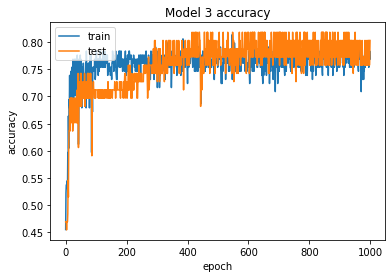

In [ ]:
import matplotlib.pyplot as plt
plt.plot(m3.history['accuracy'])
plt.plot(m3.history['val_accuracy'])
plt.title('Model 3 accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

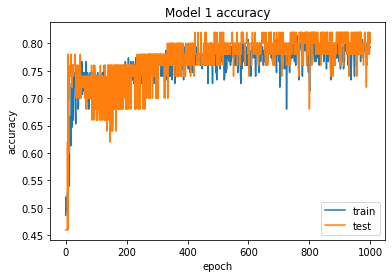

In [ ]:
import matplotlib.pyplot as plt
plt.plot(m1.history['accuracy'])
plt.plot(m1.history['val_accuracy'])
plt.title('Model 1 accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='bottom right')
plt.show()

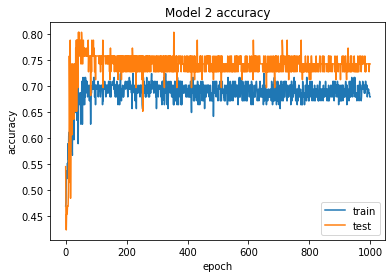

In [ ]:
import matplotlib.pyplot as plt
plt.plot(m2.history['accuracy'])
plt.plot(m2.history['val_accuracy'])
plt.title('Model 2 accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='bottom right')
plt.show()

# 6) Support Vector Machines

In [ ]:
from sklearn import datasets,preprocessing, metrics
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from statistics import mean
X_train, X_test, y_train, y_test = train_test_split(feature_set, labels, test_size=0.2)
# Create a classifier: a support vector classifier
svmclas = svm.SVC(gamma=0.0001,kernel='rbf')
#fit to the training data
svmclas.fit(X_train,y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.0001, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
y_pred = svmclas.predict(X_test)
#printing accuracy and report 

print('Accuracy score:', accuracy_score(y_true=y_test, y_pred=y_pred))
print('Report',classification_report(y_test, y_pred))

Accuracy score: 0.6078431372549019
Report               precision    recall  f1-score   support

           0       0.62      0.67      0.64        27
           1       0.59      0.54      0.57        24

    accuracy                           0.61        51
   macro avg       0.61      0.60      0.60        51
weighted avg       0.61      0.61      0.61        51



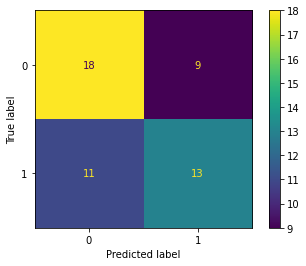

In [ ]:
#printing confusion matrix
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(svmclas, X_test, y_test)

# 7) Long Short-Term Memory(LSTMs)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(news.clean_text, labels, test_size=0.2)
from nltk import word_tokenize
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding, Input, LSTM, Conv1D, MaxPool1D, Bidirectional
from tensorflow.keras.models import Model

maxlen = -1
for i in news.clean_text:
    tokens = nltk.word_tokenize(i)
    if(maxlen<len(tokens)):
        maxlen = len(tokens)

# Create a tokenizer to tokenize the words and create sequences of tokenized words
tokenizer = Tokenizer(num_words = total_words)
tokenizer.fit_on_texts(X_train)
train_sequences = tokenizer.texts_to_sequences(X_train)
test_sequences = tokenizer.texts_to_sequences(X_test)

padded_train = pad_sequences(train_sequences,maxlen = 40, padding = 'post', truncating = 'post')
padded_test = pad_sequences(test_sequences,maxlen = 40, truncating = 'post')
print(padded_train[0])

[  69  217 2053    6  147 3360   39   17 1716   77    1 2279    6 2547
 2548  171    2  477   11   17 1886  163    1 1717 3361  434    1 4048
    1   78  133   12  364  348  127 7063  559   19   58  828]


In [ ]:
#Sequential Model
model = Sequential()

# embeddidng layer
model.add(Embedding(total_words, output_dim = 128))
# model.add(Embedding(total_words, output_dim = 240))


# LSTM
model.add((LSTM(128))) # no of neurons

# Dense layers
model.add(Dense(128, activation = 'relu'))
model.add(Dense(1,activation= 'sigmoid')) # reason: we do binary classification here
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, None, 128)         10307584  
_________________________________________________________________
lstm_6 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_21 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 129       
Total params: 10,455,809
Trainable params: 10,455,809
Non-trainable params: 0
_________________________________________________________________


In [ ]:
y_train = np.asarray(y_train)
model.fit(padded_train, y_train, batch_size = 64, validation_split = 0.1, epochs = 30)

Epoch 1/30
3/3 [==============================] - 3s 482ms/step - loss: 0.6928 - acc: 0.5569 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 2/30
3/3 [==============================] - 1s 221ms/step - loss: 0.6867 - acc: 0.8045 - val_loss: 0.6930 - val_acc: 0.5000
Epoch 3/30
3/3 [==============================] - 1s 226ms/step - loss: 0.6746 - acc: 0.8931 - val_loss: 0.6923 - val_acc: 0.4500
Epoch 4/30
3/3 [==============================] - 1s 222ms/step - loss: 0.6442 - acc: 0.9092 - val_loss: 0.6866 - val_acc: 0.6000
Epoch 5/30
3/3 [==============================] - 1s 222ms/step - loss: 0.5600 - acc: 0.9791 - val_loss: 0.6567 - val_acc: 0.7000
Epoch 6/30
3/3 [==============================] - 1s 221ms/step - loss: 0.3293 - acc: 0.9413 - val_loss: 0.8700 - val_acc: 0.6000
Epoch 7/30
3/3 [==============================] - 1s 222ms/step - loss: 0.1207 - acc: 0.9499 - val_loss: 1.1722 - val_acc: 0.6500
Epoch 8/30
3/3 [==============================] - 1s 236ms/step - loss: 0.0530 - acc: 0.99

In [ ]:
pred = model.predict(padded_test)
prediction = []
for i in range(len(pred)):
    if pred[i].item() >= 0.5:
        prediction.append(1)
    else:
        prediction.append(0)
accuracy = accuracy_score(list(y_test), prediction)

print("Model Accuracy : ", accuracy)

Model Accuracy :  0.7058823529411765
